In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


In [3]:
from modules.data_handling import load_data, load_and_normalize_data
from modules.model_training import train_and_predict_single_gp
from modules.model_training import GPModel, to_torch
from modules.fusion_methods import product_fusion
from modules.fusion_methods import compute_neg_log_like


import torch
from tqdm import tqdm

from gpytorch.means import ZeroMean
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.metrics import mean_standardized_log_loss


import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

from numpyro import distributions as dist
import jax
import jax.numpy as jnp
import jax.random as random

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_x64()

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [301]:
# ------------ Load and normalize data --------- #
# dataset_name = "autos"
# dataset_name = "breastcancer"
# dataset_name = "housing"
# dataset_name = "forest"
dataset_name = "stock"

split=0
X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,split,)

print('input dim: ', X_train.shape[1])
print("training size: ", len(y_train))
print("test size: ", len(y_test))

input dim:  11
training size:  483
test size:  53


In [302]:
# check that the entire dataset has zero mean (I didn't do this, but Trevor :-))
print(np.mean(np.vstack([X_train,X_test]),axis=0))
print(np.mean(np.concatenate([y_train,y_test]),axis=0))

# I did normalize the intputs and outputs to have unit variance
print(np.std(np.vstack([X_train,X_test]),axis=0))
print(np.std(np.concatenate([y_train,y_test]),axis=0))

[ 5.35689202e-06  4.34737246e-06  4.28131514e-06 -3.03161970e-07
 -4.30116930e-07 -1.86662247e-06  5.54218274e-07  3.95108468e-07
  3.31736120e-07 -1.22985982e-06 -1.49198843e-07]
-7.846592012888539e-07
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.9999999999999999


## Single GP

In [304]:
# Fit a GP with ARD-RBF kernel as the baseline

test_preds, train_preds = train_and_predict_single_gp(X_train,y_train,X_test,X_train,
                            kappa=2,lambdaa=2,
                            mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean (using ConstantMean())
                            lr=0.1,
                            training_iter=100,
                            initialiaze_hyper=False,  # if false, kappa and lambdaa are not used for initializing the hyperparameter
                            )

# compute the negative log-likelihood (log-loss) on test data:
print("nlpd train:", mean_standardized_log_loss(train_preds, torch.from_numpy(y_train)).numpy())
print("nlpd test:", mean_standardized_log_loss(test_preds, torch.from_numpy(y_test)).numpy())

# equivalently:
print(compute_neg_log_like(train_preds.mean.numpy(),
                           np.sqrt(train_preds.variance).numpy(),
                           y_train))
print(compute_neg_log_like(test_preds.mean.numpy(),
                           np.sqrt(test_preds.variance).numpy(),
                           y_test))

print("rmse train: ", np.sqrt(np.mean((y_train - train_preds.mean.numpy())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test - test_preds.mean.numpy())**2)))

nlpd train: 0.097666050215012
nlpd test: 0.1662390714080415
[0.09766604]
[0.16623906]
rmse train:  0.25909750487322825
rmse test:  0.29740413822692946


In [172]:
# Let us do the check that we get the same results when we train and predict using the functions:
# train_expert and predict_with_expert
from modules.model_training import train_expert, predict_with_expert


model,likelihood = train_expert(X_train,y_train,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),
                                lr=0.1,
                                training_iter=1000,
                                initialize_hyper=False,
                                )

mean_preds,std_preds,_ = predict_with_expert(model,likelihood,X_test)

print(compute_neg_log_like(mean_preds,std_preds,y_test))

[0.02969585]


Let's average results

In [305]:

nlpd = []
rmse = []
for i in tqdm(range(10)):
    try:
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

        # # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
        #                                                         normalize_y=True,  
        #                                                         normalize_x_method="max-min")

        test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                lr=0.1,
                                training_iter=100,
                                initialiaze_hyper=False, # if false, kappa and lambdaa don't matter!
                                )
        nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)

        rmse_now = np.sqrt(np.mean((test_preds.mean.numpy() - y_test)**2))

        nlpd.append(nlpd_now.squeeze())
        rmse.append(rmse_now)
    except:
        print("There was an error during hyperparameter learning.")


nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [306]:
nlpd

array([0.16623906, 0.23294891, 0.22621274, 0.17415945, 0.36714658,
       0.33055787, 0.28511666, 0.33997176, 0.25848985, 0.40566578])

In [308]:
nlpd.mean(),nlpd.std()/np.sqrt(10) # last one is the standard error of the mean

(0.2786508662837398, 0.024343467685484194)

In [309]:
rmse.mean(),rmse.std()/np.sqrt(10)

(0.3394420041241121, 0.014090499282801271)

## Let's try using an additive kernel

In [310]:
'''
AdditiveStructureKernel computes d one-dimensional kernels (using the supplied base_kernel), 
and then adds the component kernels together.
"AdditiveStructureKernel is deprecated, and will be removed in GPyTorch 2.0. "
'Please refer to the "Kernels with Additive or Product Structure" tutorial '
"in the GPyTorch docs for how to implement GPs with additive structure."
'''
kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), num_dims=X_train.shape[1])

nlpd = []
rmse = []
for i in tqdm(range(10)):
    # try:
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

        # # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
        #                                                         normalize_y=True,  
        #                                                         normalize_x_method="max-min")

        test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                kappa=2,lambdaa=2,
                                mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                kernel=kernel,
                                lr=0.1,
                                training_iter=200,
                                initialiaze_hyper=False, # if False, kappa and lambdaa are not used for initializing the hyperparameters; we just use the default values.
                                )
        nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)

        rmse_now = np.sqrt(np.mean((test_preds.mean.detach().numpy() - y_test)**2))

        nlpd.append(nlpd_now.squeeze())
        rmse.append(rmse_now)
    # except:
    #     print("There was an error during hyperparameter learning.")


nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


In [311]:
nlpd

array([0.15855886, 0.29068674, 0.11042901, 0.16759142, 0.38177738,
       0.29909993, 0.17837697, 0.22112718, 0.17104226, 0.40681154])

In [312]:
nlpd.mean(),nlpd.std()/np.sqrt(10)

(0.23855012902235923, 0.03025572608502853)

In [313]:
rmse.mean(), rmse.std()/np.sqrt(10)

(0.3068069973460011, 0.009191594199966555)

In [ ]:
%%script true
kernel = ScaleKernel(AdditiveStructureKernel(base_kernel=RBFKernel(), num_dims=X_train.shape[1]))
model = GPModel(to_torch(X_train),
                to_torch(y_train),
                GaussianLikelihood(),
                kernel=kernel,mean=ZeroMean())
for name, param in model.named_parameters():
    print(f'Parameter name: {name:42} value = {param.item():1.2f}')

## Stack GPs built on 1d projections:

We'll use the axis-aligned 1d projections for the moment, since I think it's the one
"closer" to using the additive kernel of one-dimensional kernels

In [341]:
nlpd = []
rmse = []

# proj = "axis"
proj = "random"

# project_dim = 5
project_dim = X_train.shape[1]
num_projections = 3

for split in tqdm(range(10)):
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,split)

        mean_experts = []
        std_experts = []
        std_experts_prior = []
        for d in range(num_projections):  # as many projections as dimension of X
            if proj == "random":
                  # np.random.seed(d)
                  P_proj = np.random.randn(X_train.shape[1], project_dim) / np.sqrt(project_dim)
            elif proj == "axis":
                  index = d
                  P_proj = np.array([1.0 if i == index else 0.0 for i in range(X_train.shape[1])])
                  P_proj = P_proj.reshape(-1,1)

            # test_preds, _ = train_and_predict_single_gp(
            #                         np.matmul(X_train,P_proj),
            #                         y_train,
            #                         np.matmul(X_test,P_proj),
            #                         np.matmul(X_test,P_proj),
            #                         mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
            #                         lr=0.1,
            #                         training_iter=100,
            #                         initialiaze_hyper=False, # if False, kappa and lambdaa are not used for initializing the hyperparameters; we just use the default values.
            #                         )

            # mean_experts.append(test_preds.mean.numpy())
            # std_experts.append(np.sqrt(test_preds.variance.numpy()))
      
            model,likelihood = train_expert(np.matmul(X_train,P_proj),
                                            y_train,
                                            kappa=2,lambdaa=2,
                                            mean=ZeroMean(),
                                            lr=0.1,
                                            training_iter=100,
                                            initialize_hyper=False,
                                          )

            mean_preds,std_preds,std_preds_prior = predict_with_expert(model,
                                                                       likelihood,
                                                                       np.matmul(X_test,P_proj))

            mean_experts.append(mean_preds)
            std_experts.append(std_preds)
            std_experts_prior.append(std_preds_prior)


        mean_experts = np.stack(mean_experts,axis=-1)
        std_experts = np.stack(std_experts,axis=-1)
        std_experts_prior = np.stack(std_experts_prior,axis=-1)

        # Fuse one-dimensional experts' predictions
        mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                  std_experts,
                                                  std_experts_prior,
                                                  # weighting="entropy",
                                                  weighting="entropy",
                                                #   weighting="no-weights",
                                                  normalize=True,
                                                #   method = "PoE",
                                                  method = "gPoE",
                                                  )
        
        nlpd_now = compute_neg_log_like(mean_fused,std_fused,y_test)
        nlpd.append(nlpd_now.squeeze())

        rmse_now = np.sqrt(np.mean( (mean_fused.squeeze()-y_test.squeeze())**2 ))
        rmse.append(rmse_now)
        
nlpd = np.array(nlpd)
rmse = np.array(rmse)


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


In [342]:
%%script true
for i in range(X_train.shape[1]):
    plt.scatter(X_test[:,i],y_test)
    # plt.scatter(X_test[:,i],mean_experts[:,i])

In [343]:
nlpd.mean(), nlpd.std()/np.sqrt(10)

(0.27209294126100525, 0.026868107990799868)

In [344]:
rmse.mean(), rmse.std()/np.sqrt(10)

(0.3291561661169878, 0.008354877752245327)

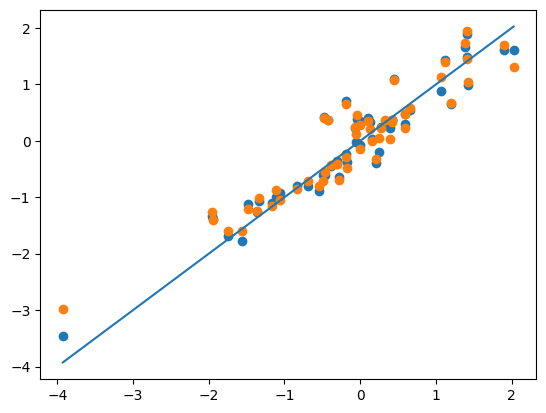

In [345]:
plt.scatter(y_test, test_preds.mean)
plt.scatter(y_test, mean_fused)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])

## Delbridge's repository

In [247]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/Randomly-Projected-Additive-GPs')


In [ ]:
from fitting.optimizing import train_to_convergence

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood

likelihood = GaussianLikelihood()
model = GPModel(to_torch(X_train),to_torch(y_train),likelihood)

print(model.covar_module.base_kernel.lengthscale)
print(likelihood.noise_covar.noise)


mll = ExactMarginalLogLikelihood(model.likelihood, model)
max_iter = train_to_convergence(model, 
                     to_torch(X_train), 
                     to_torch(y_train),
                     optimizer=torch.optim.Adam, objective=mll, 
                     max_iter=100, print_freq=1, verbose=0,lr = 0.1)
max_iter

In [ ]:
print(model.covar_module.base_kernel.lengthscale)
print(likelihood.noise_covar.noise)

In [ ]:
model.eval()
test_preds = likelihood(model(to_torch(X_test)))

print(mean_standardized_log_loss(test_preds,to_torch(y_test)))

I want to try now the function create_exact_gp

In [248]:
from training_routines import train_exact_gp

In [ ]:
model_args = {'ard': True, 'ski': False, 'grid_size': None, 'kernel_type': 'RBF', 
              'init_lengthscale_range': (0.1, 1.0), 'keops': False,
              'noise_prior': False, 'init_noise_range': (0.1,1),
              }
train_args = {'lr': 0.1, 'max_iter': 100, 'verbose': 0, 'patience': 20,
              'conv_tol': 1e-4, 'check_conv': True, 'smooth': True,
              'batch_size': None, 'checkpoint': False, 'print_freq': 1,
              'random_restarts': 5, 'optimizer': 'adam',
              }

model_metrics, pred_mean, model = train_exact_gp(trainX = to_torch(X_train), 
                                                 trainY = to_torch(y_train), 
                                                 testX = to_torch(X_test), 
                                                 testY = to_torch(y_test), 
                                                 kind = 'full', 
                                                 model_kwargs = model_args, 
                                                 train_kwargs = train_args,
                                                 )

In [ ]:
model_metrics["prior_train_nmll"], model_metrics["train_nll"]

In [ ]:
mean_standardized_log_loss(model.likelihood(model(to_torch(X_train))),
                           to_torch(y_train))

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
print(model_metrics["test_nll"]) # creo que esta mal calculado...
'''
esta usando mll = GaussianLogMarginalLikelihood para calcular este valor...
por lo que estaria calculando la log-pdf de la Gaussian multivariate, en lugar de la
media de las log-pdf de las Gaussianas univariantes.
'''

mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll.eval()
aux =model(to_torch(X_test))
print(-mll(aux,to_torch(y_test)).detach().numpy())


# deberia ser igual a esto pero no...
aux = model.likelihood(model(to_torch(X_test)))

from scipy.stats import multivariate_normal

print(
    -multivariate_normal.logpdf(y_test, 
                           aux.mean.detach().numpy(),
                           aux.covariance_matrix.detach().numpy(),
                           )
)

# este valor coincide con
print(-aux.log_prob(to_torch(y_test)).detach().numpy())

In [ ]:
# este es el que me interesa
with torch.no_grad():
    print(mean_standardized_log_loss(model.likelihood(model(to_torch(X_test))),
                           to_torch(y_test)))

In [ ]:
pred_mean

In [ ]:
model.likelihood(model(to_torch(X_test))).mean

## rff-based pogpe with weights 


In [338]:




matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))

def pogpe_with_RFGP_fixed_Omega(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM))

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 100))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))                                                                                                                            
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    #########################
    # RF-GP for log weights #
    #########################
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    # w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [339]:
M_models = 5
num_spectral_freqs = 100


svi= SVI(
        pogpe_with_RFGP_fixed_Omega,
        AutoDelta(pogpe_with_RFGP_fixed_Omega, 
                  # init_loc_fn = numpyro.infer.initialization.init_to_median,
                  init_loc_fn = numpyro.infer.init_to_sample,
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        # optim=chain(clip(10.0), adam(0.1)),
        optim = numpyro.optim.Adam(0.1),
        loss=Trace_ELBO(),
    )

print("===== Pogpe =====")
print("starting svi...")
res = svi.run(
    jax.random.PRNGKey(3),
    # 5,
    1000,  # these many iterations when using adam optimizer
    X=X_train,
    Y=y_train,
    M=M_models,
    S=num_spectral_freqs,
)

print('done!')


params = res.params
guide = AutoDelta(pogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=pogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_train)
ymu_tr_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tr = samples_posterior_predictive["w"].mean(0)
ys_tr_svi = samples_posterior_predictive["std_fused"].mean(0)

lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_train = np.sqrt(np.mean((ymu_tr_svi-y_train)**2))

samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].mean(0)
w_tst = samples_posterior_predictive["w"].mean(0)
ys_tst_svi = samples_posterior_predictive["std_fused"].mean(0)

lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_test = np.sqrt(np.mean((ymu_tst_svi-y_test)**2))



print("nlpd train: ", -lpd_pogpe_svi_train)
print("nlpd test: ", -lpd_pogpe_svi_test)

print("rmse train: ", rmse_pogpe_svi_train)
print("rmse test: ", rmse_pogpe_svi_test)


===== Pogpe =====
starting svi...


100%|██████████| 1000/1000 [00:05<00:00, 192.16it/s, init loss: 4053.1385, avg. loss [951-1000]: 2287.9129]


done!
nlpd train:  -0.27602979710114667
nlpd test:  1.6769854416385905
rmse train:  0.08623071806744967
rmse test:  0.6065806386419834


In [279]:
%%script true
samples_posterior_predictive["std_ex"]

In [280]:
%%script true
# without weights, the fused model has constant variance...
samples_posterior_predictive["std_fused"]

In [281]:
%%script true
plt.plot(res[2])

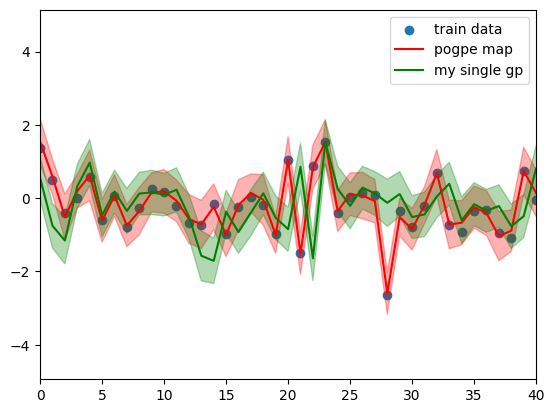

In [340]:
# plt.figure(figsize=(15,10))
plt.scatter(range(len(X_train)),y_train, label = "train data")
plt.plot(ymu_tr_svi,label = "pogpe map",color="red")
plt.fill_between(range(len(X_train)),ymu_tr_svi+2*ys_tr_svi,
                 ymu_tr_svi-2*ys_tr_svi,alpha=0.3,color="red")
plt.plot(train_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_train)),train_preds.mean.numpy()+2*np.sqrt(train_preds.variance.numpy()),
                 train_preds.mean.numpy()-2*np.sqrt(train_preds.variance.numpy()),alpha=0.3,color="green")
plt.xlim([0,40])
plt.legend();

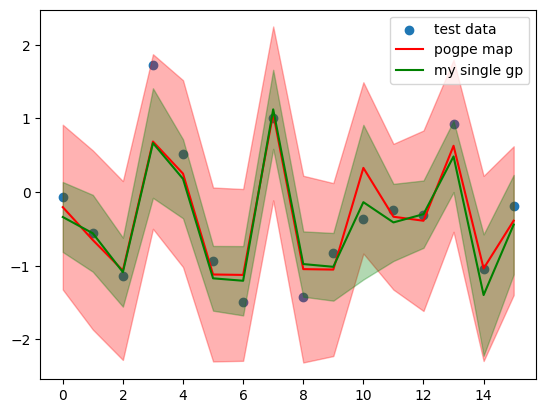

In [283]:
plt.scatter(range(len(X_test)),y_test, label = "test data")
plt.plot(ymu_tst_svi,label = "pogpe map",color="red")
plt.fill_between(range(len(X_test)),ymu_tst_svi+2*ys_tst_svi,
                 ymu_tst_svi-2*ys_tst_svi,alpha=0.3,color="red")
plt.plot(test_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_test)),test_preds.mean.numpy()+2*np.sqrt(test_preds.variance.numpy()),
                 test_preds.mean.numpy()-2*np.sqrt(test_preds.variance.numpy()),alpha=0.3,color="green")

plt.legend();

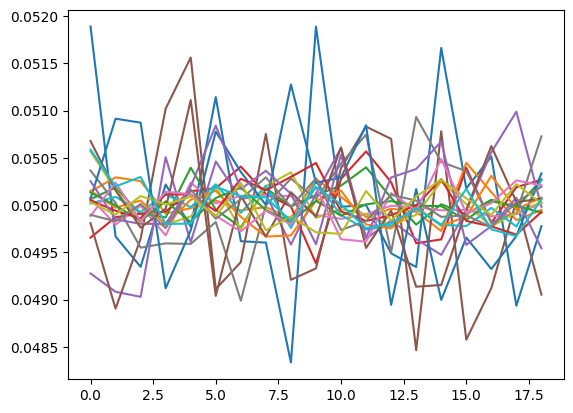

In [81]:
# %%script true
for i in range(M_models):
    plt.plot(samples_posterior_predictive["w"].mean(0)[i,:])

In [ ]:
%%script true
numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
# numpyro.enable_x64()


# %% POGPEEEEE (MCMC)

new_dict = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    new_dict[f"{new_key}"] = value


miMCMC = NUTS(
    pogpe_with_RFGP_fixed_Omega,
    # max_tree_depth=2,
    # max_tree_depth=(10, 5),
    max_tree_depth=(5, 5),
    # find_heuristic_step_size=True,
    # init_strategy=numpyro.infer.initialization.init_to_median,
    init_strategy = numpyro.infer.initialization.init_to_value(values=new_dict),
)

fer = MCMC(
    miMCMC,
    num_chains=4,
    num_samples=500,
    num_warmup=500,
    thinning=1,
    progress_bar=True,
    chain_method="parallel",
)

print("starting MCMC...")
fer.run(
    jax.random.PRNGKey(3),
    X_train,
    Y=y_train,
    y_test=y_train,  # this is line is for computing the lpd of y_train
    M=M_models,
    S=num_spectral_freqs,
)

print('MCMC done!')

miSamples = fer.get_samples()


predict = numpyro.infer.Predictive(pogpe_with_RFGP_fixed_Omega, miSamples)
preds = predict(
    jax.random.PRNGKey(3),
    X_test,
    Y=None,
    M=M_models,
    y_test=y_test,  # this line is for computing the lpd of y_test
    S = num_spectral_freqs,
)




In [ ]:
%%script true

lpd_pogpe_mcmc_train = np.mean(
    jax.nn.logsumexp(miSamples["lpd_point"], axis=0) - np.log(
    miSamples["lpd_point"].shape[0]
)
)

lpd_pogpe_mcmc_test = np.mean(
    jax.nn.logsumexp(preds["lpd_point"], axis=0) - np.log(
    preds["lpd_point"].shape[0]
)
)

ymu_tr_pogpe = miSamples["mean_fused"].mean(0)
ymu_tst_pogpe = preds["mean_fused"].mean(0)

rmse_pogpe_mcmc_train = np.sqrt(np.mean((ymu_tr_pogpe-y_train)**2))
rmse_pogpe_mcmc_test = np.sqrt(np.mean((ymu_tst_pogpe-y_test)**2))


print("nlpd train: ", -lpd_pogpe_mcmc_train)
print("nlpd test: ", -lpd_pogpe_mcmc_test)


print("rmse train: ", rmse_pogpe_mcmc_train)
print("rmse test: ", rmse_pogpe_mcmc_test)

In [ ]:
%%script true
miSamples["std_fused"].mean(0)

## alternative rff-based pogpe without weights

In [284]:
def my_pogpe(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM))

    assert Omega_fixed.shape == (S,DIM)

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        var_logstd_ex = numpyro.sample("kernel_var_exp_logstd", dist.HalfNormal(1.0))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample("theta_logstd_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_mu_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 100.0))
            lengthscale_logstd_ex = numpyro.sample('ell_logstd_ex', dist.HalfNormal(scale = 100.0))

            
    assert lengthscale_mu_ex.shape == (M,DIM)
    assert lengthscale_logstd_ex.shape == (M,DIM)
    assert theta_mu_ex.shape == (M,2*S)
    assert theta_logstd_ex.shape == (M,2*S)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))    
    matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))   
    #
    # =============== EXPERTS' MEANS  =============== #                                                                                                                   
    Omega_mu_ex = vdivide( Omega_fixed, lengthscale_mu_ex)     # shape = (M,S,DIM)
    assert Omega_mu_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_mu_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1/jnp.sqrt(S)*Phi_mu_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_mu_ex.shape == (M, N, 2*S)
    #
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_mu_ex,theta_mu_ex) )    
    assert mu_ex.shape == (M,N)
    # ========================================== #

    # =============== EXPERTS' LOGSTDS  =============== #                                                                                                                   
    Omega_logstd_ex = vdivide( Omega_fixed, lengthscale_logstd_ex)     # shape = (M,S,DIM)
    assert Omega_logstd_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logstd_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1/jnp.sqrt(S)*Phi_logstd_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_logstd_ex.shape == (M, N, 2*S)
    #
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd_ex),2*S) * theta_logstd_ex
    logstd_ex = numpyro.deterministic("logstd_ex", matmul_vmapped(Phi_logstd_ex,theta_logstd_ex) )   
    std_ex =  numpyro.deterministic("std_ex", jnp.exp(logstd_ex) )
    assert logstd_ex.shape == (M,N)
    assert std_ex.shape == (M,N)
    # ========================================== #



    # #########################
    # # RF-GP for log weights #
    # #########################
    # with numpyro.plate("M", M, dim=-2):
    #     # set uninformative log-normal priors on our three kernel hyperparameters
    #     var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
    #     # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

    #     with numpyro.plate('2S', 2*S):
    #         theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
    #                                                     scale=1.0)) # I'm not considering signal power here!
            
    #     with numpyro.plate("DIM", DIM):
    #         lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    # assert lengthscale_logw.shape == (M,DIM)

    # # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    # theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    # assert theta_logw.shape == (M,2*S)


    # Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    # ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    # Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    # Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    # logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    # assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    # w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [285]:
M_models = 5

num_spectral_freqs = 100

guide = AutoDelta(my_pogpe, 
                  # init_loc_fn = numpyro.infer.initialization.init_to_median,
                  # init_loc_fn = numpyro.infer.initialization.init_to_uniform,
                  init_loc_fn = numpyro.infer.init_to_sample,
                  )
# guide = AutoNormal(my_pogpe, 
#                   # init_loc_fn = numpyro.infer.initialization.init_to_median,
#                   # init_loc_fn = numpyro.infer.initialization.init_to_uniform,
#                   init_loc_fn = numpyro.infer.init_to_sample,
#                   )
svi= SVI(
        my_pogpe,
        guide,
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        # optim=chain(clip(10.0), adam(0.005)),
        optim = numpyro.optim.Adam(0.1),
        loss=Trace_ELBO(),
    )

print("===== Pogpe =====")
print("starting svi...")
res = svi.run(
    jax.random.PRNGKey(30),
    # 5,
    300,  # these many iterations when using adam optimizer
    X=X_train,
    Y=y_train,
    M=M_models,
    S=num_spectral_freqs,
)

print('done!')


params = res.params
# guide = AutoDelta(my_pogpe)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=my_pogpe, 
                                       guide=guide, params=params, num_samples=100)

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_train)

# ## == Creo que tambien puede hacer en dos pasos: == ##
# # Paso 1: obtengo samples de la guide
# predictive = Predictive(guide, params=params, num_samples=1)
# samples_guide = predictive(jax.random.PRNGKey(3), 
#                              X=X_train, 
#                              Y=None, 
#                              M=M_models,
#                              S=num_spectral_freqs,
#                              y_test=y_train)
# # Paso 2: obtengo samples de la predictive usando las samples de la guide
# predictive = Predictive(my_pogpe, samples_guide)
# samples_posterior_predictive = predictive(jax.random.PRNGKey(3), 
#                              X=X_train, 
#                              Y=None, 
#                              M=M_models,
#                              S=num_spectral_freqs,
#                              y_test=y_train)


ymu_tr_svi = samples_posterior_predictive["mean_fused"].mean(0)
ys_tr_svi = samples_posterior_predictive["std_fused"].mean(0)
w_tr = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_train = np.sqrt(np.mean((ymu_tr_svi-y_train)**2))

samples_posterior_predictive = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=M_models,
                                                         S=num_spectral_freqs,
                                                         y_test=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].mean(0)
ys_tst_svi = samples_posterior_predictive["std_fused"].mean(0)
w_tst = samples_posterior_predictive["w"].mean(0)

lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
rmse_pogpe_svi_test = np.sqrt(np.mean((ymu_tst_svi-y_test)**2))



print("nlpd train: ", -lpd_pogpe_svi_train)
print("nlpd test: ", -lpd_pogpe_svi_test)

print("rmse train: ", rmse_pogpe_svi_train)
print("rmse test: ", rmse_pogpe_svi_test)


===== Pogpe =====
starting svi...


100%|██████████| 300/300 [00:01<00:00, 251.12it/s, init loss: 4875.4351, avg. loss [286-300]: 3035.9000]


done!
nlpd train:  -0.3019973751194917
nlpd test:  0.816128855443049
rmse train:  0.14730713857252706
rmse test:  0.3910105335332129


In [286]:
np.sqrt(np.mean((y_test - y_train.mean())**2))

0.9436669744541243

In [287]:
%%script true
samples_posterior_predictive["std_ex"]

In [288]:
%%script true
samples_posterior_predictive["std_fused"]

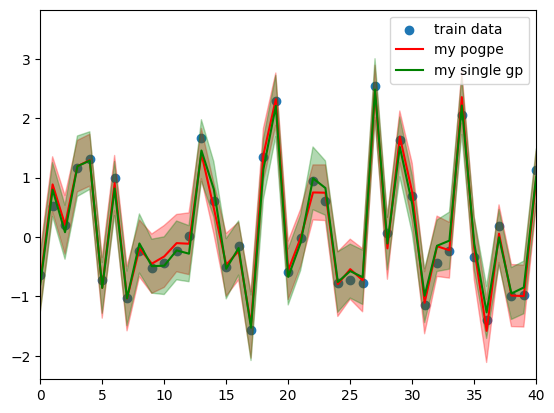

In [289]:
# plt.figure(figsize=(15,10))
plt.scatter(range(len(X_train)),y_train, label = "train data")
plt.plot(ymu_tr_svi,label = "my pogpe",color="red")
plt.fill_between(range(len(X_train)),ymu_tr_svi+2*ys_tr_svi,
                 ymu_tr_svi-2*ys_tr_svi,alpha=0.3,color="red")
plt.plot(train_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_train)),train_preds.mean.numpy()+2*np.sqrt(train_preds.variance.numpy()),
                 train_preds.mean.numpy()-2*np.sqrt(train_preds.variance.numpy()),alpha=0.3,color="green")
plt.xlim([0,40])
plt.legend();

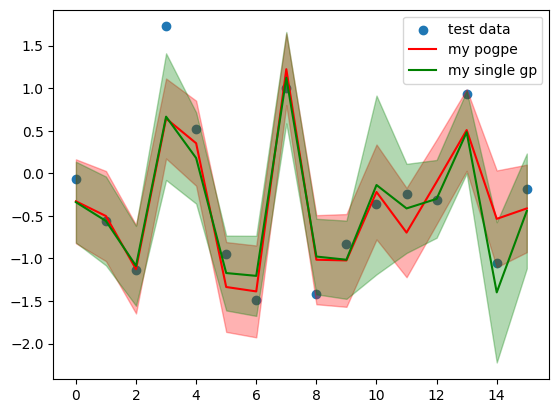

In [290]:
plt.scatter(range(len(X_test)),y_test, label = "test data")
plt.plot(ymu_tst_svi,label = "my pogpe",color="red")
plt.fill_between(range(len(X_test)),ymu_tst_svi+2*samples_posterior_predictive["std_fused"].mean(0),
                 ymu_tst_svi-2*samples_posterior_predictive["std_fused"].mean(0),alpha=0.3,color="red")
plt.plot(test_preds.mean.numpy(), label = "my single gp",color="green")
plt.fill_between(range(len(X_test)),test_preds.mean.numpy()+2*np.sqrt(test_preds.variance.numpy()),
                 test_preds.mean.numpy()-2*np.sqrt(test_preds.variance.numpy()),alpha=0.3,color="green")

plt.legend();

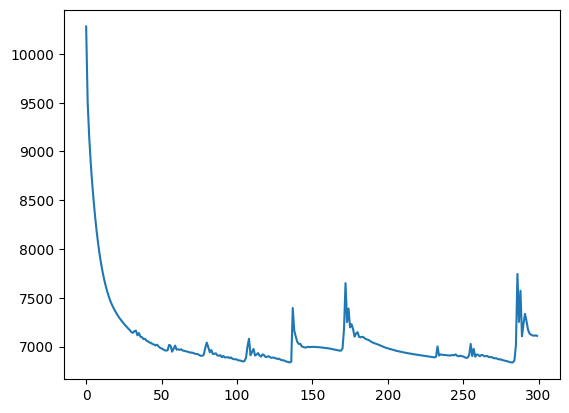

In [160]:
plt.plot(res[2])

In [166]:
samples_posterior_predictive["mu_ex"][90]

Array([[-3.06300469e-02,  6.93677033e-02,  6.08453601e-02,
        -3.65914007e-03,  9.13361697e-02,  1.05589732e-01,
         1.83486597e-01,  1.35626132e-01, -1.11639458e-01,
         2.16129489e-01,  5.20710419e-02,  6.75025400e-02,
         1.66395701e-01, -1.00775251e-01,  4.60895031e-02,
        -1.09734248e-01, -1.38760695e-01, -1.29382060e-02,
         1.72288275e-02],
       [ 1.38574947e-02, -9.89166381e-02,  4.13807358e-01,
         1.72252215e+00,  5.79814869e-01, -4.41112966e-02,
         1.19619935e+00,  1.84292167e+00, -1.40830259e-01,
         1.75447376e+00, -3.22318771e-01,  1.68624888e+00,
         5.14028678e-01,  4.57406819e-02, -6.33030131e-02,
         7.60735860e-01,  1.97103406e-01,  3.46794910e-01,
         1.40337493e+00],
       [-1.32358833e+00, -6.43314661e-01, -1.76365603e+00,
        -1.74460041e+00, -1.50218764e+00, -2.45778831e+00,
        -1.98213169e+00, -2.13915427e+00, -2.69970839e+00,
        -2.33119466e+00, -2.18184907e+00, -1.64192094e+00,
    

In [167]:
# %%script true



# %% POGPEEEEE (MCMC)

# new_dict = {}
# for key, value in params.items():
#     # print(key)
#     new_key = key.replace("_auto_loc","")
#     new_dict[f"{new_key}"] = value


kernel = NUTS(
    my_pogpe,
    # max_tree_depth=2,
    # max_tree_depth=(10, 5),
    max_tree_depth=(5, 5),
    # find_heuristic_step_size=True,
    # init_strategy=numpyro.infer.initialization.init_to_median,
    init_strategy = numpyro.infer.initialization.init_to_sample,
    # init_strategy = numpyro.infer.initialization.init_to_value(values=new_dict),
)

fer = MCMC(
    kernel,
    num_chains=4,
    num_samples=500,
    num_warmup=500,
    thinning=1,
    progress_bar=True,
    chain_method="parallel",
)

print("starting MCMC...")
fer.run(
    jax.random.PRNGKey(3),
    X_train,
    Y=y_train,
    y_test=y_train,  # this is line is for computing the lpd of y_train
    M=M_models,
    S=num_spectral_freqs,
)

print('MCMC done!')

miSamples = fer.get_samples()


predict = numpyro.infer.Predictive(my_pogpe, miSamples)
preds = predict(
    jax.random.PRNGKey(3),
    X_test,
    Y=None,
    M=M_models,
    y_test=y_test,  # this line is for computing the lpd of y_test
    S = num_spectral_freqs,
)


starting MCMC...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

MCMC done!


In [168]:
# %%script true

lpd_pogpe_mcmc_train = np.mean(
    jax.nn.logsumexp(miSamples["lpd_point"], axis=0) - np.log(
    miSamples["lpd_point"].shape[0]
)
)

lpd_pogpe_mcmc_test = np.mean(
    jax.nn.logsumexp(preds["lpd_point"], axis=0) - np.log(
    preds["lpd_point"].shape[0]
)
)

ymu_tr_pogpe = miSamples["mean_fused"].mean(0)
ymu_tst_pogpe = preds["mean_fused"].mean(0)

rmse_pogpe_mcmc_train = np.sqrt(np.mean((ymu_tr_pogpe-y_train)**2))
rmse_pogpe_mcmc_test = np.sqrt(np.mean((ymu_tst_pogpe-y_test)**2))


print("nlpd train: ", -lpd_pogpe_mcmc_train)
print("nlpd test: ", -lpd_pogpe_mcmc_test)


print("rmse train: ", rmse_pogpe_mcmc_train)
print("rmse test: ", rmse_pogpe_mcmc_test)

nlpd train:  0.6589479349334199
nlpd test:  1.1286666107530356
rmse train:  0.5274253667004627
rmse test:  0.793724836690668
